In [1]:
import itertools
import functools
from typing import Iterable, Union

import networkx as nx
import rustworkx as rx

import pennylane as qml
from pennylane.wires import Wires

In [81]:
def bit_flip_mixer_2(graph: Union[nx.Graph, rx.PyGraph], b: int):
    if not isinstance(graph, (nx.Graph, rx.PyGraph)):
        raise ValueError(
            f"Input graph must be a nx.Graph or rx.PyGraph object, got {type(graph).__name__}"
        )

    if b not in [0, 1]:
        raise ValueError(f"'b' must be either 0 or 1, got {b}")

    sign = 1 if b == 0 else -1

    coeffs = []
    terms = []

    is_rx = isinstance(graph, rx.PyGraph)
    graph_nodes = graph.node_indexes() if is_rx else graph.nodes

    # In RX each node is assigned to an integer index starting from 0;
    # thus, we use the following lambda function to get node-values.
    get_nvalue = lambda i: graph.nodes()[i] if is_rx else i

    for u in graph_nodes:
        for v in graph_nodes:
            if u==v:
                i = u
                neighbours = sorted(graph.neighbors(i)) if is_rx else list(graph.neighbors(i))
                degree = len(neighbours)

                n_terms = [[qml.PauliX(get_nvalue(i))]] + [
                    [qml.Identity(get_nvalue(n)), qml.PauliZ(get_nvalue(n))] for n in neighbours
                ]
                n_coeffs = [[1, sign] for n in neighbours]

                final_terms = [qml.operation.Tensor(*list(m)).prune() for m in itertools.product(*n_terms)]
                final_coeffs = [
                    (0.5**degree) * functools.reduce(lambda x, y: x * y, list(m), 1)
                    for m in itertools.product(*n_coeffs)
                ]

                coeffs.extend(final_coeffs)
                terms.extend(final_terms)
            elif u < v and not graph.has_edge(u,v):
                neighbours_u = sorted(graph.neighbors(u)) if is_rx else list(graph.neighbors(u))
                neighbours_v = sorted(graph.neighbors(v)) if is_rx else list(graph.neighbors(v))
                neighbours   = sorted(list(set(neighbours_u) | set(neighbours_v)))
                degree       = len(neighbours)
                n_terms      = [[qml.PauliX(get_nvalue(u))@qml.PauliX(get_nvalue(v))]] +[[qml.Identity(get_nvalue(n)), qml.PauliZ(get_nvalue(n))] for n in neighbours]
                n_coeffs     = [[1, sign] for n in neighbours]
                final_terms = [qml.operation.Tensor(*list(m)).prune() for m in itertools.product(*n_terms)]
                final_coeffs = [
                    (0.5**degree) * functools.reduce(lambda x, y: x * y, list(m), 1)
                    for m in itertools.product(*n_coeffs)
                ]

                coeffs.extend(final_coeffs)
                terms.extend(final_terms)
    
    return qml.Hamiltonian(coeffs, terms)
                

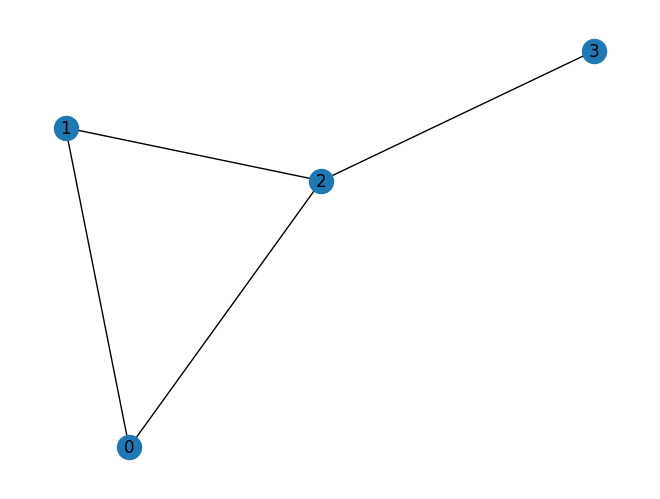

In [78]:
edges = [(0, 1), (1, 2), (2, 0), (2, 3)]
graph = nx.Graph(edges)

nx.draw(graph, with_labels=True)

In [82]:
cost_h, mixer_h = qaoa.min_vertex_cover(graph, constrained=True)
mixer_h = bit_flip_mixer_2(graph,1)
print("Cost Hamiltonian", cost_h)
print("Mixer Hamiltonian", mixer_h)

Cost Hamiltonian   (-1) [Z0]
+ (-1) [Z1]
+ (-1) [Z2]
+ (-1) [Z3]
Mixer Hamiltonian   (0.125) [X2]
+ (0.25) [X0]
+ (0.25) [X1]
+ (0.5) [X3]
+ (-0.5) [X3 Z2]
+ (-0.25) [X0 Z2]
+ (-0.25) [X0 Z1]
+ (-0.25) [X1 Z2]
+ (-0.25) [X1 Z0]
+ (-0.125) [X2 Z3]
+ (-0.125) [X2 Z0]
+ (-0.125) [X2 Z1]
+ (0.25) [X0 X3]
+ (0.25) [X1 X3]
+ (-0.25) [X0 X3 Z2]
+ (-0.25) [X0 X3 Z1]
+ (-0.25) [X1 X3 Z2]
+ (-0.25) [X1 X3 Z0]
+ (0.125) [X2 Z0 Z3]
+ (0.125) [X2 Z1 Z3]
+ (0.125) [X2 Z1 Z0]
+ (0.25) [X0 Z1 Z2]
+ (0.25) [X1 Z0 Z2]
+ (-0.125) [X2 Z1 Z0 Z3]
+ (0.25) [X0 X3 Z1 Z2]
+ (0.25) [X1 X3 Z0 Z2]


In [83]:
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

In [84]:
wires = range(4)
depth = 2

def circuit(params, **kwargs):
    for w in wires:
        qml.PauliX(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])


In [85]:
dev = qml.device("default.qubit", wires=wires)

@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(cost_h)

In [86]:
optimizer = qml.GradientDescentOptimizer()
steps = 70
params = np.array([[0.5, 0.5], [0.5, 0.5]], requires_grad=True)

In [87]:
for i in range(steps):
    params = optimizer.step(cost_function, params)

print("Optimal Parameters")
print(params)

Optimal Parameters
[[0.5        1.18818904]
 [0.5196871  0.8543746 ]]


In [88]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)


probs = probability_circuit(params[0], params[1])

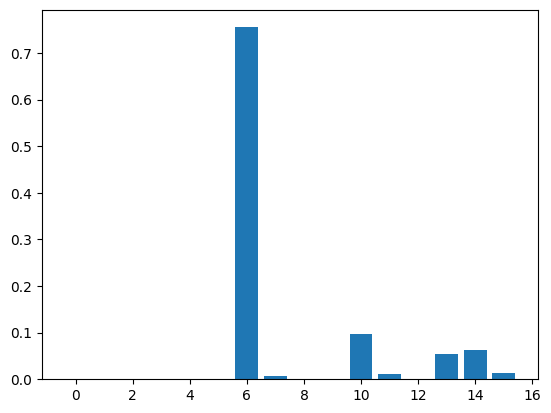

In [90]:
import matplotlib.pyplot as plt
plt.bar(range(2 ** len(wires)), probs)
plt.show()


In [23]:
def bit_flip_mixer_3(graph: Union[nx.Graph, rx.PyGraph], b: int):
    if not isinstance(graph, (nx.Graph, rx.PyGraph)):
        raise ValueError(
            f"Input graph must be a nx.Graph or rx.PyGraph object, got {type(graph).__name__}"
        )

    if b not in [0, 1]:
        raise ValueError(f"'b' must be either 0 or 1, got {b}")

    sign = 1 if b == 0 else -1

    coeffs = []
    terms = []

    is_rx = isinstance(graph, rx.PyGraph)
    graph_nodes = graph.node_indexes() if is_rx else graph.nodes

    # In RX each node is assigned to an integer index starting from 0;
    # thus, we use the following lambda function to get node-values.
    get_nvalue = lambda i: graph.nodes()[i] if is_rx else i

    for u in graph_nodes:
        for v in graph_nodes:
            if u==v:
                i = u
                neighbours = sorted(graph.neighbors(i)) if is_rx else list(graph.neighbors(i))
                degree = len(neighbours)

                n_terms = [[qml.PauliX(get_nvalue(i))]] + [
                    [qml.Identity(get_nvalue(n)), qml.PauliZ(get_nvalue(n))] for n in neighbours
                ]
                n_coeffs = [[1, sign] for n in neighbours]

                final_terms = [qml.operation.Tensor(*list(m)).prune() for m in itertools.product(*n_terms)]
                final_coeffs = [
                    (0.5**degree) * functools.reduce(lambda x, y: x * y, list(m), 1)
                    for m in itertools.product(*n_coeffs)
                ]

                coeffs.extend(final_coeffs)
                terms.extend(final_terms)
            elif u < v and not graph.has_edge(u,v):
                neighbours_u = sorted(graph.neighbors(u)) if is_rx else list(graph.neighbors(u))
                neighbours_v = sorted(graph.neighbors(v)) if is_rx else list(graph.neighbors(v))
                neighbours   = sorted(list(set(neighbours_u) | set(neighbours_v)))
                degree       = len(neighbours)
                n_terms      = [[qml.PauliX(get_nvalue(u))@qml.PauliX(get_nvalue(v))]] +[[qml.Identity(get_nvalue(n)), qml.PauliZ(get_nvalue(n))] for n in neighbours]
                n_coeffs     = [[1, sign] for n in neighbours]
                final_terms = [qml.operation.Tensor(*list(m)).prune() for m in itertools.product(*n_terms)]
                final_coeffs = [
                    (0.5**degree) * functools.reduce(lambda x, y: x * y, list(m), 1)
                    for m in itertools.product(*n_coeffs)
                ]

                coeffs.extend(final_coeffs)
                terms.extend(final_terms)
            
            
            elif u < v and graph.has_edge(u,v):
                neighbours_u = sorted(graph.neighbors(u)) if is_rx else list(graph.neighbors(u))
                neighbours_v = sorted(graph.neighbors(v)) if is_rx else list(graph.neighbors(v))
                neighbours   = sorted(list(set(neighbours_u) | set(neighbours_v))) 
                neighbours.remove(u)
                neighbours.remove(v)
                degree       = len(neighbours)
                
                
                n_terms      = [[qml.PauliX(get_nvalue(u))@qml.PauliX(get_nvalue(v))]] +[[qml.Identity(get_nvalue(n)), qml.PauliZ(get_nvalue(n))] for n in neighbours]
                n_coeffs     = [[1, sign] for n in neighbours]
                final_terms = [qml.operation.Tensor(*list(m)).prune() for m in itertools.product(*n_terms)]
                final_coeffs = [
                    (0.5**(degree+1)) * functools.reduce(lambda x, y: x * y, list(m), 1)
                    for m in itertools.product(*n_coeffs)
                ]

                coeffs.extend(final_coeffs)
                terms.extend(final_terms)
                
                n_terms      = [[qml.PauliY(get_nvalue(u))@qml.PauliY(get_nvalue(v))]] +[[qml.Identity(get_nvalue(n)), qml.PauliZ(get_nvalue(n))] for n in neighbours]
                n_coeffs     = [[1, sign] for n in neighbours]
                final_terms = [qml.operation.Tensor(*list(m)).prune() for m in itertools.product(*n_terms)]
                final_coeffs = [
                  (0.5**(degree+1)) * functools.reduce(lambda x, y: x * y, list(m), 1)
                    for m in itertools.product(*n_coeffs)
                ]

                coeffs.extend(final_coeffs)
                terms.extend(final_terms)
            
                
    return qml.Hamiltonian(coeffs, terms)

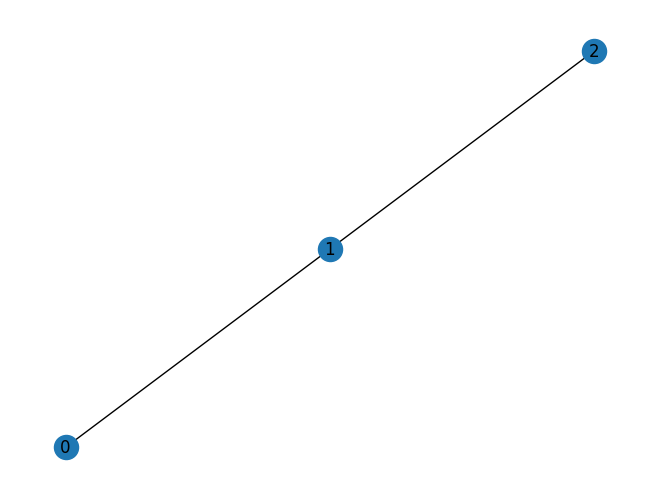

In [32]:
edges = [(0, 1), (1, 2)]
graph = nx.Graph(edges)

nx.draw(graph, with_labels=True)


H = bit_flip_mixer_3(graph,1)-bit_flip_mixer(graph,1)

In [28]:
from pennylane.qaoa.mixers import bit_flip_mixer

In [59]:
H
Hmat = qml.Hamiltonian.sparse_matrix(H).real
Hmat.toarray()

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.]])

In [60]:
def cost_h(graph: Union[nx.Graph, rx.PyGraph],b: int):
    if not isinstance(graph, (nx.Graph, rx.PyGraph)):
        raise ValueError(
            f"Input graph must be a nx.Graph or rx.PyGraph, got {type(graph).__name__}"
        )
    graph_nodes = graph.nodes
    
    for i in graph_nodes:
        ops = qml.Identity(w) for w in wires]
        coeffs = 
        ops = [qml.PauliZ(w) for w in wires]
        coeffs = [-1 for _ in wires]
    
    return cost_h